In [1]:
import numpy as np
import os, re
import os.path as osp
from collections import OrderedDict
import sqlite3
import pandas as pd
from scipy.io import loadmat
import itertools
import json
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from PIL import Image
import cv2
from tqdm import tqdm
import glob
os.chdir("../../PA_labels/")

# Merge existing dataset to PAR dataset
1. new labels
2. 0 : neg, 1 : pos, -1 : N/A

In [103]:
PAR_dataset = pd.DataFrame(columns=['path', 
                                    'bbox', 
                                    'gender', 
                                    'hair', 
                                    'shirt', 'plaid', 'stripe', 'sleeve', 'logo', 
                                    'shorts', 'skirt', 
                                    'hat', 'glasses', 'backpack', 'bag'])

In [7]:
def transform(path, 
              bbox=-1, 
              gender=-1, 
              hair=-1, 
              shirt=-1, plaid=-1, stripe=-1, sleeve=-1, logo=-1, 
              shorts=-1, skirt=-1, 
              hat=-1, glasses=-1, backpack=-1, bag=-1):
    person = {}
    person['path'] = path
    person['bbox'] = bbox
    person['gender'] = gender
    person['hair'] = hair
    person['shirt'] = shirt
    person['plaid'] = plaid
    person['stripe'] = stripe
    person['sleeve'] = sleeve
    person['logo'] = logo
    person['shorts'] = shorts
    person['skirt'] = skirt
    person['hat'] = hat
    person['glasses'] = glasses
    person['backpack'] = backpack
    person['bag'] = bag
    return person

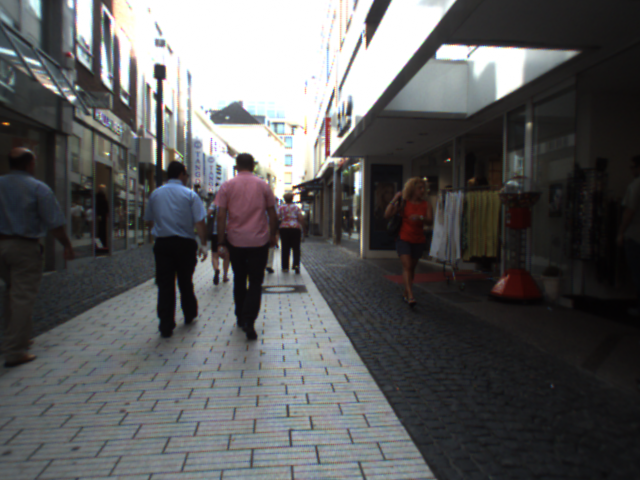

In [27]:
idx = 60
img = cv2.imread(osp.join("../../PA_labels/",parse27k.iloc[idx]['path']))
x1, y1 = bbox_transform(parse27k.iloc[idx]['bbox'])[:2]
x2, y2 = bbox_transform(parse27k.iloc[idx]['bbox'])[2:]
# cv2.rectangle(img, bbox_transform(parse27k.iloc[idx]['bbox'])[:2], bbox_transform(parse27k.iloc[idx]['bbox'])[2:], (0,0,255), 2)
# cv2.circle(img, bbox_transform(parse27k.iloc[idx]['bbox'])[:2], 5, (0,0,0), -1)
# cv2.circle(img, bbox_transform(parse27k.iloc[idx]['bbox'])[2:], 5, (0,0,0), -1)
# temp = cv2.cvtColor(img[y1:y2, x1:x2,:], cv2.COLOR_BGR2RGB)    
temp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
pil_img = Image.fromarray(temp)
pil_img

In [4]:
parse27k.iloc[4]['path']

'parse27k/sequences/log_15_8_2012_____16_28_45/image_00000240_0_rect.png'

In [3]:

img = cv2.imread(parse27k.iloc[4]['path'])
cv2.rectangle(img, bbox_transform(parse27k.iloc[4]['bbox'])[:2], bbox_transform(parse27k.iloc[4]['bbox'])[2:], (255,255,255), 2)
temp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


# Merge parse27k

### train

In [18]:
PAR_dataset = pd.DataFrame(columns=['path', 
                                    'bbox', 
                                    'gender', 
                                    'hair', 
                                    'shirt', 'plaid', 'stripe', 'sleeve', 'logo', 
                                    'shorts', 'skirt', 
                                    'hat', 'glasses', 'backpack', 'bag'])

In [2]:
parse27k = pd.read_csv("parse27k/parse27k_train_labels.csv", index_col=0)

def bbox_transform(bbox_str):
    try:
        bbox_format = re.compile(r'\((\d+),\s(\d+),\s(\d+),\s(\d+)\)')
        bbox = bbox_format.search(bbox_str).groups()
    except:
        bbox_format = re.compile(r'\((\d+).\d+,\s(\d+).\d+,\s(\d+).\d+,\s(\d+).\d+\)')
        bbox = bbox_format.search(bbox_str).groups()
    return (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]))

In [5]:
parse27k.head()

,path,pid,bbox,Orientation,Orientation8,Gender,Posture,HasBagOnShoulderLeft,HasBagOnShoulderRight,HasBagInHandLeft,HasBagInHandRight,HasTrolley,HasBackpack,isPushing,isTalkingOnPhone
0,parse27k/sequences/log_15_8_2012_____16_28_45/...,1,"(515, 202, 536, 254)",3,6,0,2,-1,-1,0,-1,2,0,2,2
1,parse27k/sequences/log_15_8_2012_____16_28_45/...,2,"(317, 209, 335, 270)",4,3,0,2,-1,0,-1,0,2,0,2,2
2,parse27k/sequences/log_15_8_2012_____16_28_45/...,3,"(334, 206, 362, 290)",4,3,0,2,-1,0,-1,0,2,0,2,2
3,parse27k/sequences/log_15_8_2012_____16_28_45/...,4,"(538, 204, 562, 275)",1,8,1,2,-1,0,0,0,2,0,2,2
4,parse27k/sequences/log_15_8_2012_____16_28_45/...,5,"(453, 205, 476, 276)",2,5,0,2,-1,1,-1,0,2,0,2,2


In [4]:
for att in ['Gender', 'HasBagOnShoulderLeft', 'HasBagOnShoulderLeft', 'HasBagOnShoulderRight', 'HasBagInHandLeft', 'HasBagInHandRight', 'HasBackpack']:
    parse27k[att].replace(0, -1, inplace=True)
    parse27k[att].replace(2, 0, inplace=True)

In [19]:
for i in tqdm(parse27k.index):
    candidate = parse27k.loc[i]
    person = transform(path=candidate['path'],
                       bbox=candidate['bbox'],
                       gender=candidate['Gender'],
                       bag=1 if (candidate['HasBagOnShoulderLeft']==1 or candidate['HasBagOnShoulderRight']==1 or candidate['HasBagInHandLeft']==1 or candidate['HasBagInHandRight']==1) else -1,
                       backpack=candidate['HasBackpack'])
    PAR_dataset = PAR_dataset.append(person, ignore_index=True)


 14%|█▍        | 2887/20359 [00:15<01:33, 186.80it/s]


 28%|██▊       | 5602/20359 [00:30<01:23, 176.90it/s]


 39%|███▉      | 8025/20359 [00:45<01:20, 152.77it/s]


 50%|█████     | 10236/20359 [01:00<01:09, 144.80it/s]


 60%|██████    | 12262/20359 [01:16<01:01, 131.23it/s]


 69%|██████▉   | 14148/20359 [01:31<00:51, 120.13it/s]


 78%|███████▊  | 15856/20359 [01:46<00:38, 116.58it/s]


 86%|████████▌ | 17450/20359 [02:01<00:33, 87.42it/s]


 92%|█████████▏| 18812/20359 [02:16<00:18, 84.80it/s]


 99%|█████████▊| 20059/20359 [02:32<00:04, 71.77it/s]


100%|██████████| 20359/20359 [02:36<00:00, 130.41it/s]

In [20]:
PAR_dataset.head()

,path,bbox,gender,hair,shirt,plaid,stripe,sleeve,logo,shorts,skirt,hat,glasses,backpack,bag
0,parse27k/sequences/log_15_8_2012_____16_28_45/...,"(515, 202, 536, 254)",0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1
1,parse27k/sequences/log_15_8_2012_____16_28_45/...,"(317, 209, 335, 270)",0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1
2,parse27k/sequences/log_15_8_2012_____16_28_45/...,"(334, 206, 362, 290)",0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1
3,parse27k/sequences/log_15_8_2012_____16_28_45/...,"(538, 204, 562, 275)",1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1
4,parse27k/sequences/log_15_8_2012_____16_28_45/...,"(453, 205, 476, 276)",0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1


In [115]:
len(PAR_dataset[PAR_dataset['gender']!=-1])

12287

In [21]:
PAR_dataset.to_csv("./PAR_dataset_parse27k_train.csv")

### test

In [22]:
PAR_dataset = pd.DataFrame(columns=['path', 
                                    'bbox', 
                                    'gender', 
                                    'hair', 
                                    'shirt', 'plaid', 'stripe', 'sleeve', 'logo', 
                                    'shorts', 'skirt', 
                                    'hat', 'glasses', 'backpack', 'bag'])

In [23]:
parse27k = pd.read_csv("parse27k/parse27k_test_labels.csv", index_col=0)

def bbox_transform(bbox_str):
    bbox_format = re.compile(r'\((\d+),\s(\d+),\s(\d+),\s(\d+)\)')
    bbox = bbox_format.search(bbox_str).groups()
    return (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]))

In [24]:
for att in ['Gender', 'HasBagOnShoulderLeft', 'HasBagOnShoulderLeft', 'HasBagOnShoulderRight', 'HasBagInHandLeft', 'HasBagInHandRight', 'HasBackpack']:
    parse27k[att].replace(0, -1, inplace=True)
    parse27k[att].replace(2, 0, inplace=True)

In [25]:
for i in tqdm(parse27k.index):
    candidate = parse27k.loc[i]
    person = transform(path=candidate['path'],
                       bbox=candidate['bbox'],
                       gender=candidate['Gender'],
                       bag=1 if (candidate['HasBagOnShoulderLeft']==1 or candidate['HasBagOnShoulderRight']==1 or candidate['HasBagInHandLeft']==1 or candidate['HasBagInHandRight']==1) else -1,
                       backpack=candidate['HasBackpack'])
    PAR_dataset = PAR_dataset.append(person, ignore_index=True)


 44%|████▎     | 2909/6655 [00:15<00:19, 187.43it/s]


 83%|████████▎ | 5523/6655 [00:30<00:06, 172.78it/s]


100%|██████████| 6655/6655 [00:37<00:00, 175.79it/s]

In [26]:
PAR_dataset.to_csv("./PAR_dataset_parse27k_test.csv")

### train

# Merge PA-100K

### Write

In [14]:
PAR_dataset = pd.DataFrame(columns=['path', 
                                    'bbox', 
                                    'gender', 
                                    'hair', 
                                    'shirt', 'plaid', 'stripe', 'sleeve', 'logo', 
                                    'shorts', 'skirt', 
                                    'hat', 'glasses', 'backpack', 'bag'])

In [15]:
pa100k = pd.read_csv("./PA-100K_anno/PA-100K_labels.csv", index_col=0)

In [127]:
set(pa100k['Glasses'])

{0, 1}

In [122]:
pa100k.columns

Index(['path', 'Female', 'AgeOver60', 'Age18-60', 'AgeLess18', 'Front', 'Side',
       'Back', 'Hat', 'Glasses', 'HandBag', 'ShoulderBag', 'Backpack',
       'HoldObjectsInFront', 'ShortSleeve', 'LongSleeve', 'UpperStride',
       'UpperLogo', 'UpperPlaid', 'UpperSplice', 'LowerStripe', 'LowerPattern',
       'LongCoat', 'Trousers', 'Shorts', 'Skirt&Dress', 'boots'],
      dtype='object')

In [18]:
for i in tqdm(pa100k.index):
    candidate = pa100k.loc[i]
    person = transform(path=candidate['path'],
                       gender=0 if candidate['Female'] else 1,
                       plaid=candidate['UpperPlaid'],
                       sleeve=candidate['LongSleeve'],
                       logo=candidate['UpperLogo'],
                       shorts=candidate['Shorts'],
                       skirt=candidate['Skirt&Dress'],
                       hat=candidate['Hat'],
                       glasses=candidate['Glasses'],                       
                       bag=1 if (candidate['HandBag']==1 or candidate['ShoulderBag']==1) else -1,
                       backpack=candidate['Backpack'])
    PAR_dataset = PAR_dataset.append(person, ignore_index=True)

  1%|▏         | 1318/100000 [00:06<08:11, 200.64it/s]


KeyboardInterrupt: 

In [143]:
PAR_dataset.loc[13741:].index

RangeIndex(start=13741, stop=113741, step=1)

In [146]:
for i in PAR_dataset.index:
    path = PAR_dataset.loc[i]['path']
    PAR_dataset.loc[i]['path'] = "pa100k/"+path

In [147]:
PAR_dataset.to_csv("./PAR_dataset_pa100k.csv")

###  train

In [24]:
pa100k.iloc[:90000].to_csv("./PAR_dataset_pa100k_train.csv")

###  test

In [ ]:
pa100k.iloc[90000:].to_csv("./PAR_dataset_pa100k_test.csv")

# Merge PETA

In [222]:
PAR_dataset = pd.DataFrame(columns=['path', 
                                    'bbox', 
                                    'gender', 
                                    'hair', 
                                    'shirt', 'plaid', 'stripe', 'sleeve', 'logo', 
                                    'shorts', 'skirt', 
                                    'hat', 'glasses', 'backpack', 'bag'])

In [210]:
branch = [i.split("/")[-1] for i in glob.glob("/media/allen/mass/PA_labels/PETA/PETA_dataset/*")]

In [211]:
peta = pd.read_csv("./PETA/{}_labels.csv".format(branch[0]), index_col=0)

imgs = sorted([os.path.join("PETA/{}/archive".format(branch[0]), f) for _, _, files in os.walk("/media/allen/mass/PA_labels/PETA/PETA_dataset/{}/archive".format(branch[0])) for f in files if ".jpg" in f or '.png' in f or '.bmp' in f])

new_persons = []
for path in imgs:
    pid = int(path.split("/")[-1].split("_")[0])
    path_col = pd.Series(data=path, index=["path"])
    new_person = path_col.append(peta[peta['pid']==pid].iloc[0])
    new_persons.append(new_person)

In [212]:
for b in branch[1:]:
    _peta = pd.read_csv("./PETA/{}_labels.csv".format(b), index_col=0)

    imgs = sorted([os.path.join("PETA/{}/archive".format(b), f) for _, _, files in os.walk("/media/allen/mass/PA_labels/PETA/PETA_dataset/{}/archive".format(b)) for f in files if ".jpg" in f or '.png' in f or '.bmp' in f])
    
    
    for path in imgs:
        try:
            pid = int(path.split("/")[-1].split("_")[0])
        except:
            pid = int(path.split("/")[-1].split(".")[0])
        path_col = pd.Series(data=path, index=["path"])
        new_person = path_col.append(_peta[_peta['pid']==pid].iloc[0])
        new_persons.append(new_person)
   

In [213]:
peta = pd.DataFrame(new_persons)

In [220]:
for i in peta.columns:
    print(i)
#     print(set(peta[i]))

path
pid
accessoryHeadphone
accessoryHairBand
accessoryHat
accessoryKerchief
accessoryMuffler
accessoryNothing
accessorySunglasses
personalLess15
personalLess30
personalLess45
personalLess60
personalLarger60
personalFemale
personalMale
hairBald
hairLong
hairShort
upperBodyCasual
upperBodyFormal
upperBodyJacket
upperBodyTshirt
upperBodySuit
upperBodySweater
upperBodyPlaid
upperBodyThinStripes
upperBodyThickStripes
upperBodyLongSleeve
upperBodyNoSleeve
upperBodyShortSleeve
upperBodyVNeck
upperBodyLogo
upperBodyOther
lowerBodyCasual
lowerBodyFormal
lowerBodyHotPants
lowerBodyJeans
lowerBodyLongSkirt
lowerBodyShortSkirt
lowerBodySuits
lowerBodyTrousers
lowerBodyCapri
lowerBodyPlaid
lowerBodyThinStripes
lowerBodyShorts
footwearBoots
footwearLeatherShoes
footwearSandals
footwearShoes
footwearSneakers
footwearStocking
carryingBackpack
carryingUmbrella
carryingFolder
carryingMessengerBag
carryingPlasticBags
carryingBabyBuggy
carryingShoppingTro
carryingLuggageCase
carryingSuitcase
carryingOthe

In [224]:
for i in tqdm(peta.index):
    candidate = peta.loc[i]
    person = transform(path=candidate['path'],
                       gender=candidate['personalMale'],
                       hair=candidate['hairLong'],
                       shirt=candidate['upperBodyTshirt'],
                       plaid=candidate['upperBodyPlaid'],
                       stripe=1 if candidate['upperBodyThinStripes'] or candidate['upperBodyThickStripes'] else 0,
                       sleeve=candidate['upperBodyLongSleeve'],
                       logo=candidate['upperBodyLogo'],
                       shorts=1 if (candidate['lowerBodyHotPants']==1 or candidate['lowerBodyShorts']==1 or candidate['lowerBodyCapri']==1) else 0,
                       skirt=1 if (candidate['lowerBodyLongSkirt']==1 or candidate['lowerBodyShortSkirt']==1) else 0,
                       hat=candidate['accessoryHat'],
                       glasses=candidate['accessorySunglasses'],                       
                       bag=1 if (candidate['carryingMessengerBag']==1 or candidate['carryingPlasticBags']==1 or candidate['carryingMessengerBag']==1) else 0,
                       backpack=candidate['carryingBackpack'])
    PAR_dataset = PAR_dataset.append(person, ignore_index=True)

100%|██████████| 17725/17725 [02:28<00:00, 119.04it/s]


In [226]:
PAR_dataset.to_csv("./PAR_dataset_peta.csv")

# Merge Duke

###  train

In [228]:
PAR_dataset = pd.DataFrame(columns=['path', 
                                    'bbox', 
                                    'gender', 
                                    'hair', 
                                    'shirt', 'plaid', 'stripe', 'sleeve', 'logo', 
                                    'shorts', 'skirt', 
                                    'hat', 'glasses', 'backpack', 'bag'])

In [231]:
duke = pd.read_csv("./DukeMTMC-attribute/train_Duke_labels.csv", index_col=0)

In [237]:
imgs = sorted([os.path.join("dukemtmc-reid/DukeMTMC-reID/bounding_box_train", f) for _, _, files in os.walk("/media/allen/mass/reid/dukemtmc-reid/DukeMTMC-reID/bounding_box_train") for f in files if ".jpg" in f or '.png' in f or '.bmp' in f])

new_persons = []
for path in imgs:
    pid = int(path.split("/")[-1].split("_")[0])
    path_col = pd.Series(data=path, index=["path"])
    new_person = path_col.append(duke[duke['pid']==pid].iloc[0])
    new_persons.append(new_person)

In [238]:
duke = pd.DataFrame(new_persons)

In [232]:
duke.columns

Index(['pid', 'backpack', 'bag', 'handbag', 'boots', 'gender', 'hat', 'shoes',
       'top', 'upblack', 'upwhite', 'upred', 'uppurple', 'upgray', 'upblue',
       'upgreen', 'upbrown', 'downblack', 'downwhite', 'downred', 'downgray',
       'downblue', 'downgreen', 'downbrown'],
      dtype='object')

In [242]:
for i in tqdm(duke.index):
    candidate = duke.loc[i]
    person = transform(path=candidate['path'],
                       gender=candidate['gender'],
                       hat=candidate['hat'],                       
                       bag=1 if (candidate['bag']==1 or candidate['handbag']==1) else 0,
                       backpack=candidate['backpack'])
    PAR_dataset = PAR_dataset.append(person, ignore_index=True)

100%|██████████| 16522/16522 [01:58<00:00, 139.51it/s]


In [247]:
PAR_dataset.to_csv("./PAR_dataset_duke_train.csv")

###  test

In [41]:
PAR_dataset = pd.DataFrame(columns=['path', 
                                    'bbox', 
                                    'gender', 
                                    'hair', 
                                    'shirt', 'plaid', 'stripe', 'sleeve', 'logo', 
                                    'shorts', 'skirt', 
                                    'hat', 'glasses', 'backpack', 'bag'])

In [42]:
duke = pd.read_csv("./DukeMTMC-attribute/test_Duke_labels.csv", index_col=0)

In [46]:
duke.head()

,path,pid,backpack,bag,handbag,boots,gender,hat,shoes,top,...,upblue,upgreen,upbrown,downblack,downwhite,downred,downgray,downblue,downgreen,downbrown
0,dukemtmc-reid/DukeMTMC-reID/bounding_box_test/...,2,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,dukemtmc-reid/DukeMTMC-reID/bounding_box_test/...,2,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,dukemtmc-reid/DukeMTMC-reID/bounding_box_test/...,2,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,dukemtmc-reid/DukeMTMC-reID/bounding_box_test/...,2,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,dukemtmc-reid/DukeMTMC-reID/bounding_box_test/...,2,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [44]:
imgs = sorted([os.path.join("dukemtmc-reid/DukeMTMC-reID/bounding_box_test", f) for _, _, files in os.walk("/media/allen/mass/reid/dukemtmc-reid/DukeMTMC-reID/bounding_box_test") for f in files if ".jpg" in f or '.png' in f or '.bmp' in f])

new_persons = []
for path in imgs:
    pid = int(path.split("/")[-1].split("_")[0])
    path_col = pd.Series(data=path, index=["path"])
    new_person = path_col.append(duke[duke['pid']==pid].iloc[0])
    new_persons.append(new_person)

In [45]:
duke = pd.DataFrame(new_persons)

In [47]:
for i in tqdm(duke.index):
    candidate = duke.loc[i]
    person = transform(path=candidate['path'],
                       gender=candidate['gender'],
                       hat=candidate['hat'],                       
                       bag=1 if (candidate['bag']==1 or candidate['handbag']==1) else 0,
                       backpack=candidate['backpack'])
    PAR_dataset = PAR_dataset.append(person, ignore_index=True)

100%|██████████| 17661/17661 [01:50<00:00, 160.51it/s]


In [48]:
PAR_dataset.to_csv("./PAR_dataset_duke_test.csv")

# Merge Market

###  train

In [253]:
PAR_dataset = pd.DataFrame(columns=['path', 
                                    'bbox', 
                                    'gender', 
                                    'hair', 
                                    'shirt', 'plaid', 'stripe', 'sleeve', 'logo', 
                                    'shorts', 'skirt', 
                                    'hat', 'glasses', 'backpack', 'bag'])

In [254]:
market = pd.read_csv("./Market-1501_Attribute/train_Market_labels.csv", index_col=0)

In [256]:
imgs = sorted([os.path.join("market1501/bounding_box_train", f) for _, _, files in os.walk("/media/allen/mass/reid/market1501/bounding_box_train") for f in files if ".jpg" in f or '.png' in f or '.bmp' in f])

new_persons = []
for path in imgs:
    pid = int(path.split("/")[-1].split("_")[0])
    path_col = pd.Series(data=path, index=["path"])
    new_person = path_col.append(market[market['pid']==pid].iloc[0])
    new_persons.append(new_person)

In [258]:
market = pd.DataFrame(new_persons)

In [260]:
market.columns

Index(['path', 'pid', 'young', 'teenager', 'adult', 'old', 'backpack', 'bag',
       'handbag', 'clothes', 'down', 'up', 'hair', 'hat', 'gender', 'upblack',
       'upwhite', 'upred', 'uppurple', 'upyellow', 'upgray', 'upblue',
       'upgreen', 'downblack', 'downwhite', 'downpink', 'downpurple',
       'downyellow', 'downgray', 'downblue', 'downgreen', 'downbrown'],
      dtype='object')

In [276]:
market[market['clothes']==0].iloc[0]['path']

'market1501/bounding_box_train/0010_c1s6_027271_05.jpg'

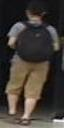

In [302]:

img = cv2.imread("/media/allen/mass/reid/" + market[market['backpack']==1].iloc[120]['path'])
# cv2.rectangle(img, bbox_transform(parse27k.iloc[4]['bbox'])[:2], bbox_transform(parse27k.iloc[4]['bbox'])[2:], (255,255,255), 2)
temp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

In [303]:
for i in tqdm(market.index):
    candidate = market.loc[i]
    person = transform(path=candidate['path'],
                       gender=candidate['gender'],
                       hair=candidate['hair'],
                       hat=candidate['hat'],    
                       skirt=1 if candidate['clothes']==0 else 0,
                       bag=1 if (candidate['bag']==1 or candidate['handbag']==1) else 0,
                       backpack=candidate['backpack'])
    PAR_dataset = PAR_dataset.append(person, ignore_index=True)

100%|██████████| 12936/12936 [01:40<00:00, 129.28it/s]


In [304]:
PAR_dataset.to_csv("./PAR_dataset_market.csv")

###  test

In [49]:
PAR_dataset = pd.DataFrame(columns=['path', 
                                    'bbox', 
                                    'gender', 
                                    'hair', 
                                    'shirt', 'plaid', 'stripe', 'sleeve', 'logo', 
                                    'shorts', 'skirt', 
                                    'hat', 'glasses', 'backpack', 'bag'])

In [50]:
market = pd.read_csv("./Market-1501_Attribute/test_Market_labels.csv", index_col=0)

In [63]:
0 in market['pid'].values.tolist()

False

In [65]:
imgs = sorted([os.path.join("market1501/bounding_box_test", f) for _, _, files in os.walk("/media/allen/mass/reid/market1501/bounding_box_test") for f in files if ".jpg" in f or '.png' in f or '.bmp' in f])

new_persons = []
for path in imgs:
    pid = int(path.split("/")[-1].split("_")[0])
    if pid not in market['pid'].values.tolist():
        continue
    path_col = pd.Series(data=path, index=["path"])
    new_person = path_col.append(market[market['pid']==pid].iloc[0])
    new_persons.append(new_person)

In [66]:
market = pd.DataFrame(new_persons)

In [67]:
for i in tqdm(market.index):
    candidate = market.loc[i]
    person = transform(path=candidate['path'],
                       gender=candidate['gender'],
                       hair=candidate['hair'],
                       hat=candidate['hat'],    
                       skirt=1 if candidate['clothes']==0 else 0,
                       bag=1 if (candidate['bag']==1 or candidate['handbag']==1) else 0,
                       backpack=candidate['backpack'])
    PAR_dataset = PAR_dataset.append(person, ignore_index=True)

100%|██████████| 13115/13115 [01:15<00:00, 138.14it/s]


In [68]:
PAR_dataset.to_csv("./PAR_dataset_market_test.csv")

# Merge WIDER

### train

In [169]:
PAR_dataset = pd.DataFrame(columns=['path', 
                                    'bbox', 
                                    'gender', 
                                    'hair', 
                                    'shirt', 'plaid', 'stripe', 'sleeve', 'logo', 
                                    'shorts', 'skirt', 
                                    'hat', 'glasses', 'backpack', 'bag'])

In [170]:
wider = pd.read_csv("./wider_attribute_annotation/wider_attribute_trainval_annos.csv", index_col=0)

In [171]:
wider.columns

Index(['path', 'scene', 'bbox', 'Male', 'longHair', 'sunglass', 'Hat',
       'Tshiirt', 'longSleeve', 'formal', 'shorts', 'jeans', 'longPants',
       'skirt', 'faceMask', 'logo', 'stripe'],
      dtype='object')

In [172]:
for i in tqdm(wider.index):
    candidate = wider.loc[i]
    bbox = candidate['bbox']
    bbox = bbox.replace("]", ")")
    bbox = bbox.replace("[", "(")
    person = transform(path="wider/" + candidate['path'],
                       bbox=bbox,
                       gender=candidate['Male'],
                       hair=candidate['longHair'],
                       hat=candidate['Hat'], 
                       logo=candidate['logo'],
                       shirt=candidate['Tshiirt'],
                       sleeve=candidate['longSleeve'],
                       stripe=candidate['stripe'],
                       shorts=candidate['shorts'],
                       skirt=candidate['skirt'],
                       glasses=candidate['sunglass'])
    PAR_dataset = PAR_dataset.append(person, ignore_index=True)

100%|██████████| 28345/28345 [04:18<00:00, 73.53it/s] 


In [173]:
PAR_dataset.to_csv("./PAR_dataset_wider_train.csv")

### test

In [165]:
PAR_dataset = pd.DataFrame(columns=['path', 
                                    'bbox', 
                                    'gender', 
                                    'hair', 
                                    'shirt', 'plaid', 'stripe', 'sleeve', 'logo', 
                                    'shorts', 'skirt', 
                                    'hat', 'glasses', 'backpack', 'bag'])

In [166]:
wider = pd.read_csv("./wider_attribute_annotation/wider_attribute_test_annos.csv", index_col=0)

In [167]:
for i in tqdm(wider.index):
    candidate = wider.loc[i]
    bbox = candidate['bbox']
    bbox = bbox.replace("]", ")")
    bbox = bbox.replace("[", "(")

    person = transform(path="wider/" + candidate['path'],
                       bbox=bbox,
                       gender=candidate['Male'],
                       hair=candidate['longHair'],
                       hat=candidate['Hat'], 
                       logo=candidate['logo'],
                       shirt=candidate['Tshiirt'],
                       sleeve=candidate['longSleeve'],
                       stripe=candidate['stripe'],
                       shorts=candidate['shorts'],
                       skirt=candidate['skirt'],
                       glasses=candidate['sunglass'])
    PAR_dataset = PAR_dataset.append(person, ignore_index=True)

100%|██████████| 29179/29179 [04:14<00:00, 114.48it/s]


In [168]:
PAR_dataset.to_csv("./PAR_dataset_wider_test.csv")

# Merge total

In [34]:
data_split = "train"

### train

In [32]:
datasets = ["parse27k_train", "pa100k_train", "peta", "duke_train", "market_train", "wider_train"]
PAR = pd.read_csv("./PAR_dataset_{}.csv".format(datasets[0]), index_col=0, dtype={'gender':int,
                                                                                  'hair': int,
                                                                                  'shirt': int, 
                                                                                  'plaid': int, 
                                                                                  'stripe': int, 
                                                                                  'sleeve': int, 
                                                                                  'logo': int, 
                                                                                  'shorts': int, 
                                                                                  'skirt': int, 
                                                                                  'hat': int, 
                                                                                  'glasses': int, 
                                                                                  'backpack': int, 
                                                                                  'bag': int, 
                                                                                  'path': str,})

In [33]:
for dataset in datasets[1:]:
    _df = pd.read_csv("./PAR_dataset_{}.csv".format(dataset), index_col=0, dtype={'gender':int,
                                                                                  'hair': int,
                                                                                  'shirt': int, 
                                                                                  'plaid': int, 
                                                                                  'stripe': int, 
                                                                                  'sleeve': int, 
                                                                                  'logo': int, 
                                                                                  'shorts': int, 
                                                                                  'skirt': int, 
                                                                                  'hat': int, 
                                                                                  'glasses': int, 
                                                                                  'backpack': int, 
                                                                                  'bag': int, 
                                                                                  'path': str})
    PAR = pd.concat([PAR, _df], axis=0)

In [232]:
category_names = ['gender', 'hair', 'shirt', 'plaid', 'stripe', 'sleeve',
       'logo', 'shorts', 'skirt', 'hat', 'glasses', 'backpack', 'bag']
with open("./PAR_{}_dataset.txt".format(data_split), 'w') as f:
    for i in range(len(PAR)):
        path = PAR.iloc[i]['path']
        bbox = bbox_transform(PAR.iloc[i]['bbox']) if PAR.iloc[i]['bbox'] != '-1' and PAR.iloc[i]['bbox'] != -1 else (-1, -1, -1, -1)    
        attrs = PAR.iloc[i][category_names].values.tolist()
        line = "{} {} {} {} {} ".format(path, bbox[0], bbox[1], bbox[2], bbox[3])
        for attr in attrs:
            line += "{} ".format(attr)
        f.write(line + "\n")
        

### crop image for existing bbox

### test

In [233]:
datasets = ["parse27k_test", "pa100k_test", "peta", "duke_test", "market_test", "wider_test"]
PAR = pd.read_csv("./PAR_dataset_{}.csv".format(datasets[0]), index_col=0, dtype={'gender':int,
                                                                                  'hair': int,
                                                                                  'shirt': int, 
                                                                                  'plaid': int, 
                                                                                  'stripe': int, 
                                                                                  'sleeve': int, 
                                                                                  'logo': int, 
                                                                                  'shorts': int, 
                                                                                  'skirt': int, 
                                                                                  'hat': int, 
                                                                                  'glasses': int, 
                                                                                  'backpack': int, 
                                                                                  'bag': int, 
                                                                                  'path': str,})

In [234]:
for dataset in datasets[1:]:
    _df = pd.read_csv("./PAR_dataset_{}.csv".format(dataset), index_col=0, dtype={'gender':int,
                                                                                  'hair': int,
                                                                                  'shirt': int, 
                                                                                  'plaid': int, 
                                                                                  'stripe': int, 
                                                                                  'sleeve': int, 
                                                                                  'logo': int, 
                                                                                  'shorts': int, 
                                                                                  'skirt': int, 
                                                                                  'hat': int, 
                                                                                  'glasses': int, 
                                                                                  'backpack': int, 
                                                                                  'bag': int, 
                                                                                  'path': str})
    PAR = pd.concat([PAR, _df], axis=0)

In [179]:
PAR.to_csv("./PAR_test_dataset.csv")

In [235]:
category_names = ['gender', 'hair', 'shirt', 'plaid', 'stripe', 'sleeve',
       'logo', 'shorts', 'skirt', 'hat', 'glasses', 'backpack', 'bag']
with open("./PAR_test_dataset.txt", 'w') as f:
    for i in range(len(PAR)):
        path = PAR.iloc[i]['path']
        bbox = bbox_transform(PAR.iloc[i]['bbox']) if PAR.iloc[i]['bbox'] != '-1' and PAR.iloc[i]['bbox'] != -1 else (-1, -1, -1, -1)    
        attrs = PAR.iloc[i][category_names].values.tolist()
        line = "{} {} {} {} {} ".format(path, bbox[0], bbox[1], bbox[2], bbox[3])
        for attr in attrs:
            line += "{} ".format(attr)
        f.write(line + "\n")
        

### stats

In [99]:
counts = []
for col in PAR.columns[2:]:
    counts.append(pd.crosstab(PAR[col], columns="count").values)

In [100]:
counts = np.array(counts).squeeze()
cumsums = counts.cumsum(axis=1)

In [101]:
cumsums

array([[ 2774, 46082, 94335],
       [37703, 78964, 94335],
       [49402, 87126, 94335],
       [66610, 92629, 94335],
       [47669, 92098, 94335],
       [39397, 59373, 94335],
       [38695, 84023, 94335],
       [47889, 87687, 94335],
       [31941, 87871, 94335],
       [ 7123, 80407, 94335],
       [38432, 89983, 94335],
       [30233, 76076, 94335],
       [39641, 73666, 94335]])

In [102]:
counts

array([[ 2774, 43308, 48253],
       [37703, 41261, 15371],
       [49402, 37724,  7209],
       [66610, 26019,  1706],
       [47669, 44429,  2237],
       [39397, 19976, 34962],
       [38695, 45328, 10312],
       [47889, 39798,  6648],
       [31941, 55930,  6464],
       [ 7123, 73284, 13928],
       [38432, 51551,  4352],
       [30233, 45843, 18259],
       [39641, 34025, 20669]])

In [104]:
%pylab
import seaborn as sns
plt.figure(figsize=(100,100))
sns.set()

# y-axis in bold
rc('font', weight='bold') 
 
# The position of the bars on the x-axis
r = range(len(PAR.columns[2:]))
 
# Names of group and bar width
names = PAR.columns[2:]
barWidth = 0.5
 
# Create brown bars
plt.bar(r, counts[:,0], color='#de1010', edgecolor='white', width=barWidth, label="N/A")
# Create green bars (middle), on top of the firs ones
plt.bar(r, counts[:,1], bottom=cumsums[:,0], color='#d7e623', edgecolor='white', width=barWidth, label="positive")
# Create green bars (top)
plt.bar(r, counts[:,2], bottom=cumsums[:,1], color='#212ef3', edgecolor='white', width=barWidth, label="negative")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5,  prop={'size': 15})
# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("attribute")
plt.ylabel("counts")
plt.title("Person Attribute Dataset [[{}]]".format(data_split))
# Show graphic
plt.show()


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


# Accuracy

In [216]:
PAR_gt = pd.read_csv("./PAR_train_dataset.csv", index_col=0)

/home/allen/.pyenv/versions/3.6.8/envs/py368/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [197]:
def bbox_transform(bbox_str):
    x1, y1, x2, y2 = bbox_str.split(",")
    x1 = x1.split("(")[-1]
    y2 = y2.split(")")[0]    
    return (int(float(x1)), int(float(y1)), int(float(x2)), int(float(y2)))

In [222]:
category_names = ['gender', 'hair', 'shirt', 'plaid', 'stripe', 'sleeve',
       'logo', 'shorts', 'skirt', 'hat', 'glasses', 'backpack', 'bag']
dataset = []
for i in range(len(PAR_gt)):
    path = PAR_gt.iloc[i]['path']
    bbox = bbox_transform(PAR_gt.iloc[i]['bbox']) if PAR_gt.iloc[i]['bbox'] != '-1' and PAR_gt.iloc[i]['bbox'] != -1 else -1    
    attrs = PAR_gt.iloc[i][category_names].values.tolist()
    dataset.append((path, bbox, attrs))
        

ValueError: not enough values to unpack (expected 4, got 1)

In [224]:
PAR_gt.iloc[i]['bbox'] != ''-1

True

In [218]:
path, bbox, attrs = dataset[i]

IndexError: list index out of range

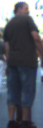

In [213]:
img = Image.open(osp.join("/media/allen/mass/PAR", path))
img.crop(bbox)


In [215]:
attrs

[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1]

In [134]:
PAR_gt.iloc[i]['bbox'] != 1

True

In [117]:
PAR.columns

Index(['path', 'bbox', 'gender', 'hair', 'shirt', 'plaid', 'stripe', 'sleeve',
       'logo', 'shorts', 'skirt', 'hat', 'glasses', 'backpack', 'bag'],
      dtype='object')

In [121]:
gt_result = PAR[['gender', 'hair', 'shirt', 'plaid', 'stripe', 'sleeve',
       'logo', 'shorts', 'skirt', 'hat', 'glasses', 'backpack', 'bag']].head().values

In [123]:
gt_result

array([[ 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1],
       [ 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1],
       [ 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1],
       [ 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1],
       [ 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1]])

In [124]:
(gt_result == 1).astype(float)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [122]:
gt_pos = np.sum((gt_result == 1).astype(float), axis=0)
gt_neg = np.sum((gt_result == -1).astype(float), axis=0)
pt_pos = np.sum((gt_result == 1).astype(float) * (pt_result == 1).astype(float), axis=0)
pt_neg = np.sum((gt_result == -1).astype(float) * (pt_result == -1).astype(float), axis=0)

array([5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])